# Forecasting Exchange Rates with Long Short-Term Memory Networks using the RNN SageMaker Algorithm

**Blog post:** https://fg-research.com/blog/product/posts/rnn-fx-forecasting.html

## 1. Environment set-up

1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Forecasting (RNN) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-p5cr7ncmdcziw).

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
# SageMaker algorithm ARN, replace the placeholder below with your AWS Marketplace ARN
algo_arn = "arn:aws:sagemaker:<...>"

Install the dependencies.

In [2]:
!pip install yfinance pyti

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 37.4 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 54.7 MB/s eta 0:00:0000:0100:01
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=279105 sha256=1de3e69f830d026581464192a23097c63e6715020790efbebf69578050c5a269
  Stored in directory: /home/ec2-user/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


Set up the SageMaker session.

In [3]:
import io
import sagemaker
import warnings
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pyti.momentum import momentum
from pyti.rate_of_change import rate_of_change
from pyti.moving_average_convergence_divergence import moving_average_convergence_divergence
from pyti.simple_moving_average import simple_moving_average
from pyti.relative_strength_index import relative_strength_index
from pyti.bollinger_bands import middle_bollinger_band, upper_bollinger_band, lower_bollinger_band
from pyti.commodity_channel_index import commodity_channel_index
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, accuracy_score, f1_score
warnings.filterwarnings(action='ignore')

# SageMaker session
sagemaker_session = sagemaker.Session()

# SageMaker role
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.4xlarge"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Define the sequence lengths.

In [4]:
# number of time steps used as input
context_length = 5

# number of time steps to output
prediction_length = 1

## 2. Data preparation

Download the data.

In [5]:
dataset = yf.download(tickers="EURUSD=X", start="2022-08-01", end="2024-08-01")

[*********************100%%**********************]  1 of 1 completed


In [6]:
dataset.shape

(522, 6)

In [7]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-01,1.020825,1.027749,1.020960,1.020825,1.020825,0
2022-08-02,1.026136,1.029315,1.018371,1.026136,1.026136,0
2022-08-03,1.015569,1.020762,1.012320,1.015569,1.015569,0
2022-08-04,1.015765,1.023248,1.015600,1.015765,1.015765,0
2022-08-05,1.024779,1.024905,1.014363,1.024779,1.024779,0


In [8]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-07-25,1.083952,1.086437,1.082931,1.083952,1.083952,0
2024-07-26,1.085128,1.086850,1.084269,1.085128,1.085128,0
2024-07-29,1.085376,1.087193,1.080310,1.085376,1.085376,0
2024-07-30,1.081947,1.083776,1.079995,1.081947,1.081947,0
2024-07-31,1.081607,1.085187,1.080871,1.081607,1.081607,0


Calculate the technical indicators.

In [9]:
# MA with a period of 10
dataset["MA"] = simple_moving_average(
    data=dataset["Close"],
    period=10
)

# MACD with short- and long-term periods of 12 and 26
dataset["MACD"] = moving_average_convergence_divergence(
    data=dataset["Close"],
    short_period=12,
    long_period=26
)

# ROC with a period of 2
dataset["ROC"] = rate_of_change(
    data=dataset["Close"],
    period=2
)

# Momentum with a period of 4
dataset["Momentum"] = momentum(
    data=dataset["Close"],
    period=4
)

# RSI with a period of 10
dataset["RSI"] = relative_strength_index(
    data=dataset["Close"],
    period=10
)

# BB with period of 20
dataset["MiddleBB"] = middle_bollinger_band(
    data=dataset["Close"],
    period=20
)

dataset["LowerBB"] = upper_bollinger_band(
    data=dataset["Close"],
    period=20
)

dataset["UpperBB"] = lower_bollinger_band(
    data=dataset["Close"],
    period=20
)

# CCI with a period of 20
dataset["CCI"] = commodity_channel_index(
    close_data=dataset["Close"],
    low_data=dataset["Low"],
    high_data=dataset["High"],
    period=20
)

Move the target to the first column.

In [10]:
dataset = dataset[["Close"] + dataset.columns.drop("Close").tolist()]

Drop the unnecessary columns.

In [11]:
dataset.drop(labels=["Adj Close", "Volume"], axis=1, inplace=True)

Drop the missing values.

In [12]:
dataset.dropna(inplace=True)

In [13]:
dataset.shape

(497, 13)

In [14]:
dataset.head()

,Close,Open,High,Low,MA,MACD,ROC,Momentum,RSI,MiddleBB,LowerBB,UpperBB,CCI
Date,,,,,,,,,,,,,
2022-09-05,0.990943,0.990943,0.994352,0.988084,0.997253,-0.007534,-0.431065,-0.011563,33.258533,1.008215,1.033679,0.982750,-47.048266
2022-09-06,0.995223,0.995223,0.998532,0.986514,0.997381,-0.007208,0.431933,-0.008682,39.716067,1.006988,1.032473,0.981502,-37.041596
2022-09-07,0.989795,0.989795,0.995520,0.987781,0.996691,-0.007157,-0.545389,-0.005438,34.951185,1.005437,1.031142,0.979731,-38.786578
2022-09-08,0.999570,0.999570,1.002908,0.993345,0.996957,-0.005987,0.987582,0.008627,47.544178,1.003912,1.027083,0.980740,-13.738662
2022-09-09,1.001202,1.001202,1.011225,1.000931,0.997365,-0.004877,0.163202,0.005979,49.361970,1.002388,1.021752,0.983024,5.542294


In [15]:
dataset.tail()

,Close,Open,High,Low,MA,MACD,ROC,Momentum,RSI,MiddleBB,LowerBB,UpperBB,CCI
Date,,,,,,,,,,,,,
2024-07-25,1.083952,1.083952,1.086437,1.082931,1.088833,0.003712,-0.102975,-0.005966,48.200696,1.082955,1.097415,1.068496,3.360871
2024-07-26,1.085128,1.085128,1.086850,1.084269,1.088619,0.003189,0.108514,-0.003852,51.121455,1.083811,1.096556,1.071067,3.846632
2024-07-29,1.085376,1.085376,1.087193,1.080310,1.088301,0.002719,0.022795,0.000306,51.757072,1.084538,1.095815,1.073260,-1.077227
2024-07-30,1.081947,1.081947,1.083776,1.079995,1.087480,0.001842,-0.315933,-0.002005,43.120107,1.084959,1.095136,1.074782,-8.574104
2024-07-31,1.081607,1.081607,1.085187,1.080871,1.086615,0.001022,-0.031368,-0.003521,42.343047,1.085353,1.094292,1.076415,-8.090891


Visualize the data.

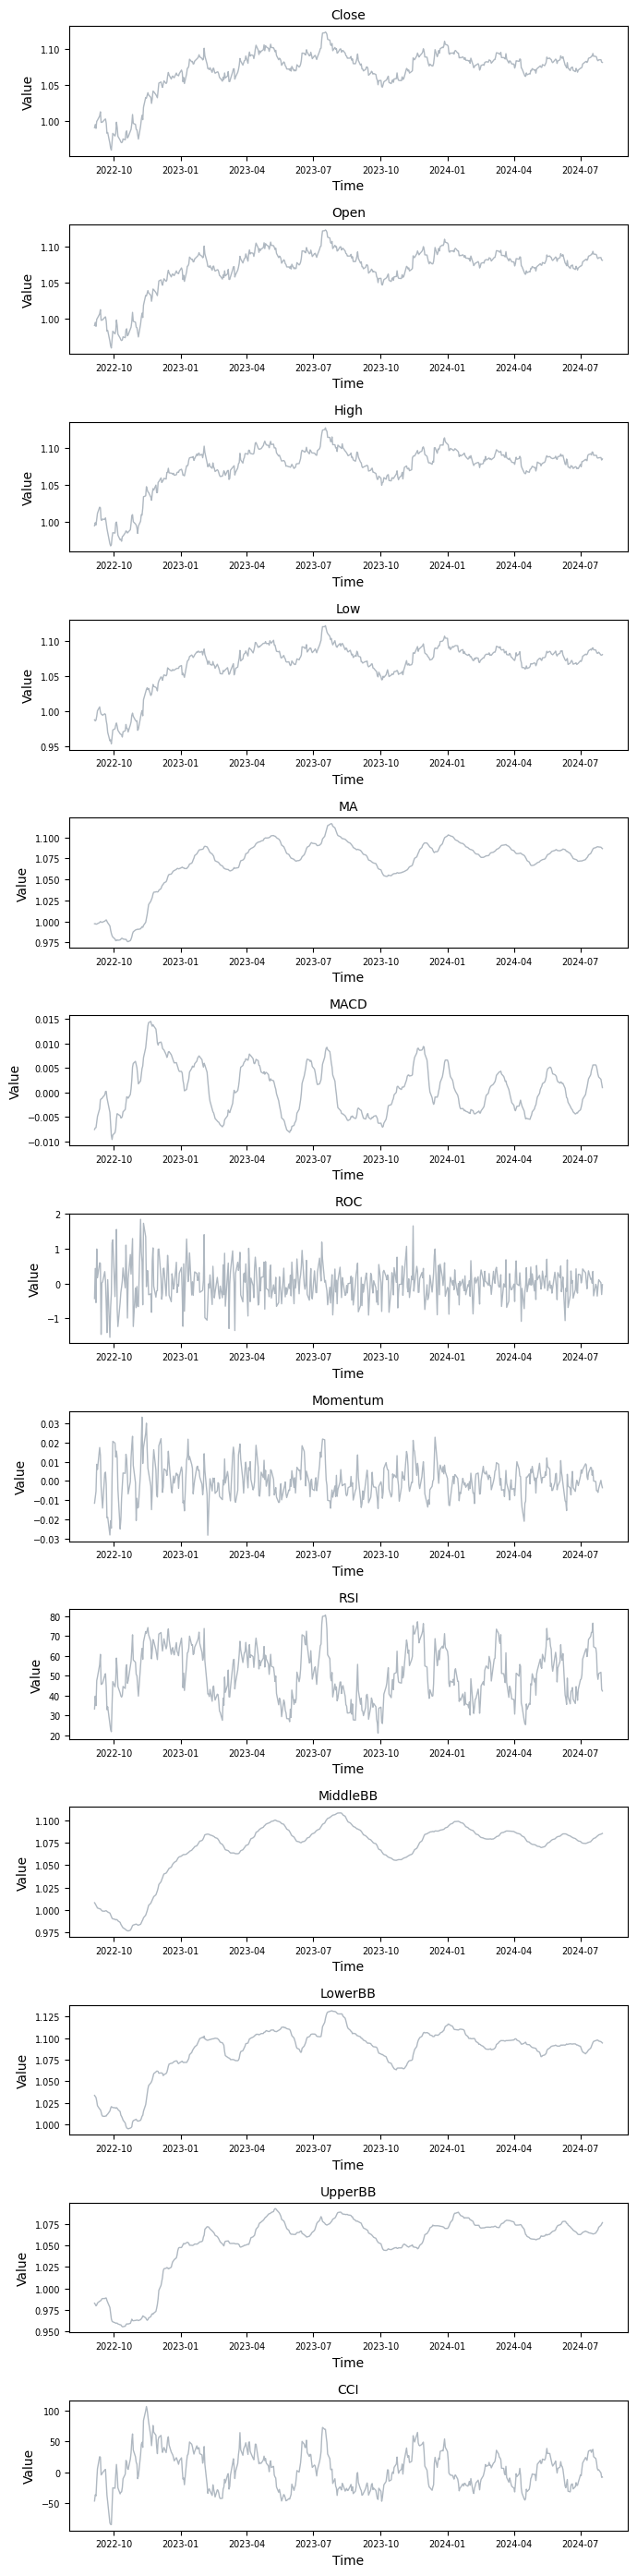

In [16]:
fig, axs = plt.subplots(nrows=dataset.shape[1], ncols=1, sharex=True, figsize=(7, 28))
for i in range(dataset.shape[1]):
    axs[i].plot(dataset.iloc[:, i], color="#AFB8C1", lw=1)
    axs[i].set_title(f"{dataset.columns[i]}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.tight_layout()
fig.show()

Rename the columns.

In [17]:
dataset.columns = ["y"] + [f"x{i}" for i in range(dataset.shape[1] - 1)]

In [18]:
dataset.shape

(497, 13)

In [19]:
dataset.head()

,y,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
Date,,,,,,,,,,,,,
2022-09-05,0.990943,0.990943,0.994352,0.988084,0.997253,-0.007534,-0.431065,-0.011563,33.258533,1.008215,1.033679,0.982750,-47.048266
2022-09-06,0.995223,0.995223,0.998532,0.986514,0.997381,-0.007208,0.431933,-0.008682,39.716067,1.006988,1.032473,0.981502,-37.041596
2022-09-07,0.989795,0.989795,0.995520,0.987781,0.996691,-0.007157,-0.545389,-0.005438,34.951185,1.005437,1.031142,0.979731,-38.786578
2022-09-08,0.999570,0.999570,1.002908,0.993345,0.996957,-0.005987,0.987582,0.008627,47.544178,1.003912,1.027083,0.980740,-13.738662
2022-09-09,1.001202,1.001202,1.011225,1.000931,0.997365,-0.004877,0.163202,0.005979,49.361970,1.002388,1.021752,0.983024,5.542294


In [20]:
dataset.tail()

,y,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
Date,,,,,,,,,,,,,
2024-07-25,1.083952,1.083952,1.086437,1.082931,1.088833,0.003712,-0.102975,-0.005966,48.200696,1.082955,1.097415,1.068496,3.360871
2024-07-26,1.085128,1.085128,1.086850,1.084269,1.088619,0.003189,0.108514,-0.003852,51.121455,1.083811,1.096556,1.071067,3.846632
2024-07-29,1.085376,1.085376,1.087193,1.080310,1.088301,0.002719,0.022795,0.000306,51.757072,1.084538,1.095815,1.073260,-1.077227
2024-07-30,1.081947,1.081947,1.083776,1.079995,1.087480,0.001842,-0.315933,-0.002005,43.120107,1.084959,1.095136,1.074782,-8.574104
2024-07-31,1.081607,1.081607,1.085187,1.080871,1.086615,0.001022,-0.031368,-0.003521,42.343047,1.085353,1.094292,1.076415,-8.090891


Split the data.

In [21]:
test_size = 30

In [22]:
training_dataset = dataset.iloc[:- test_size]

In [23]:
test_dataset = dataset.iloc[- test_size - context_length:]

Upload the data to S3.

In [24]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False),
    bucket=bucket,
    key="training_data.csv"
)

In [25]:
training_data

's3://sagemaker-eu-west-1-661670223746/training_data.csv'

In [26]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_dataset.to_csv(index=False),
    bucket=bucket,
    key="test_data.csv"
)

In [27]:
test_data

's3://sagemaker-eu-west-1-661670223746/test_data.csv'

## 3. Training

Train the model.

In [28]:
# create the estimator
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "context-length": context_length,
        "prediction-length": prediction_length,
        "sequence-stride": 1,
        "cell-type": "lstm",
        "hidden-size-1": 100,
        "hidden-size-2": 50,
        "hidden-size-3": 0,
        "activation": "lecun",
        "dropout": 0,
        "batch-size": 16,
        "lr": 0.001,
        "lr-decay": 0.99,
        "epochs": 200
    }
)

# run the training job
estimator.fit({"training": training_data})

INFO:sagemaker:Creating training-job with name: rnn-tsf-v1-0-2024-08-11-05-56-55-404


2024-08-11 05:56:55 Starting - Starting the training job...
2024-08-11 05:57:10 Starting - Preparing the instances for training...
2024-08-11 05:57:40 Downloading - Downloading the training image...............
2024-08-11 06:00:11 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-11 06:00:45,703 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-08-11 06:00:45,704 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-08-11 06:00:45,705 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-08-11 06:00:45,705 sagemaker-training-toolkit INFO     Failed to parse hyperparameter activation value lecun to Json.
Returning the value itself
2024-08-11 06:00:45,705 sagemaker-training-toolkit INFO     Failed to parse hyperparameter cell-type 

## 4. Inference

Generate the test set predictions.

In [29]:
# create the transformer
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
)

# run the transform job
transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating model package with name: rnn-tsf-v1-0-2024-08-11-06-02-09-042


.........

INFO:sagemaker:Creating model with name: rnn-tsf-v1-0-2024-08-11-06-02-09-042-2024-08-11-06-02-54-555


INFO:sagemaker:Creating transform job with name: rnn-tsf-v1-0-2024-08-11-06-02-55-203


2024-08-11T06:10:39,027 [WARN ] main org.pytorch.serve.util.ConfigManager - Your torchserve instance can access any URL to load models. When deploying to production, make sure to limit the set of allowed_urls in config.properties
2024-08-11T06:10:39,029 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2024-08-11T06:10:39,084 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2024-08-11T06:10:39,201 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.11.0
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metrics config path: /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
Number of GPUs: 0
Number of CPUs: 16
Max heap size: 15736 M
Python executable: /opt/conda/bin/python3.10
Config file: /etc/sagemaker-ts.properties
In

Load the test set predictions from S3.

In [30]:
# get the forecasts from S3
predictions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/test_data.csv.out"
)

# cast the forecasts to data frame
predictions = pd.read_csv(io.StringIO(predictions), dtype=float)

# drop the out-of-sample forecast
predictions = predictions.iloc[:-1]

# add the dates
predictions.index = test_dataset.index

# add the actual values
predictions["y"] = test_dataset["y"]

# add the actual and predicted percentage changes
predictions["r"] = predictions["y"] / predictions["y"].shift(periods=1) - 1
predictions["r_mean"] = predictions["y_mean"] / predictions["y"].shift(periods=1) - 1

# drop the missing values
predictions.dropna(inplace=True)

In [31]:
predictions.shape

(30, 5)

In [32]:
predictions.head()

,y_mean,y_std,y,r,r_mean
Date,,,,,
2024-06-19,1.074455,0.002478,1.074229,0.000150,0.000360
2024-06-20,1.074646,0.002491,1.075153,0.000860,0.000388
2024-06-21,1.072118,0.002487,1.070641,-0.004197,-0.002824
2024-06-24,1.070292,0.002471,1.068776,-0.001742,-0.000326
2024-06-25,1.073226,0.002527,1.073272,0.004207,0.004164


In [33]:
predictions.tail()

,y_mean,y_std,y,r,r_mean
Date,,,,,
2024-07-25,1.085186,0.002785,1.083952,-0.001030,0.000108
2024-07-26,1.085991,0.002781,1.085128,0.001085,0.001881
2024-07-29,1.086226,0.002763,1.085376,0.000228,0.001011
2024-07-30,1.082455,0.002677,1.081947,-0.003159,-0.002691
2024-07-31,1.082691,0.002652,1.081607,-0.000314,0.000688


Regress the actual returns on the predicted returns.

In [34]:
model = sm.OLS(endog=predictions["r"], exog=sm.add_constant(predictions["r_mean"])).fit(disp=0)
results = model.get_prediction(sm.add_constant(predictions["r"].sort_values()))
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      r   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     50.98
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           9.05e-08
Time:                        06:11:19   Log-Likelihood:                 154.79
No. Observations:                  30   AIC:                            -305.6
Df Residuals:                      28   BIC:                            -302.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.385      0.7

Visualize the predicted returns.

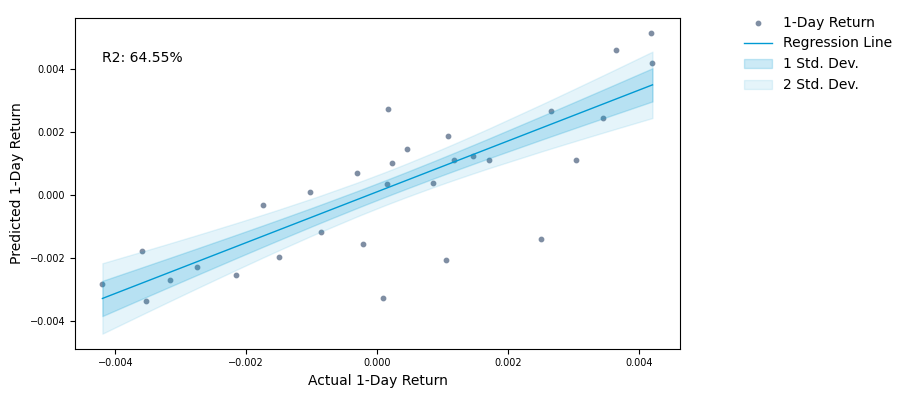

In [35]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.scatter(predictions["r"].values, predictions["r_mean"].values, color="#7f8ea3", s=10, label="1-Day Return")
ax.plot(predictions["r"].sort_values(), results.predicted_mean, color="#009ad3", lw=1, label="Regression Line")
ax.fill_between(predictions["r"].sort_values(), results.predicted_mean + (results.var_pred_mean ** 0.5), results.predicted_mean - (results.var_pred_mean ** 0.5), color="#009ad3", alpha=0.2, lw=1, label="1 Std. Dev.")
ax.fill_between(predictions["r"].sort_values(), results.predicted_mean + 2 * (results.var_pred_mean ** 0.5), results.predicted_mean - 2 * (results.var_pred_mean ** 0.5), color="#009ad3", alpha=0.1, lw=1, label="2 Std. Dev.")
ax.text(x=predictions["r"].min(), y=predictions["r"].max(), s=f'R2: {format(model.rsquared, ".2%")}')
ax.set(xlabel="Actual 1-Day Return", ylabel="Predicted 1-Day Return")
ax.xaxis.set_tick_params(labelbottom=True)
ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=7)
fig.legend(bbox_to_anchor=(1, 0, 0.3, 1), frameon=False)
fig.tight_layout()
fig.show()

Visualize the predicted prices.

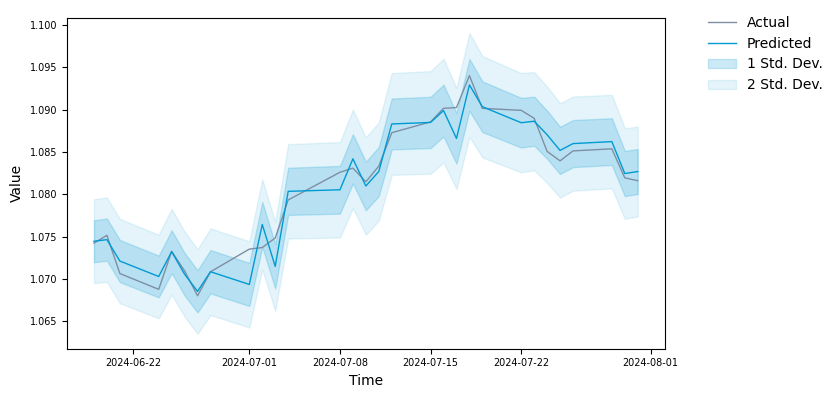

In [36]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(predictions.index, predictions["y"].values, color="#7f8ea3", lw=1, label="Actual")
ax.plot(predictions.index, predictions["y_mean"].values, color="#009ad3", lw=1, label="Predicted")
ax.fill_between(predictions.index, predictions["y_mean"].values + predictions["y_std"].values, predictions["y_mean"].values - predictions["y_std"].values, color="#009ad3", alpha=0.2, lw=1, label="1 Std. Dev.")
ax.fill_between(predictions.index, predictions["y_mean"].values + 2 * predictions["y_std"].values, predictions["y_mean"].values - 2 * predictions["y_std"].values, color="#009ad3", alpha=0.1, lw=1, label="2 Std. Dev.")
ax.set(xlabel="Time", ylabel="Value")
ax.xaxis.set_tick_params(labelbottom=True)
ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=7)
fig.legend(bbox_to_anchor=(1, 0, 0.2, 1), frameon=False)
fig.tight_layout()
fig.show()

Calculate the performance metrics.

In [37]:
metrics = pd.DataFrame(
    columns=["Metric", "Value"],
    data=[
        {"Metric": "RMSE", "Value": root_mean_squared_error(y_true=predictions["y"], y_pred=predictions["y_mean"])},
        {"Metric": "MAE", "Value": mean_absolute_error(y_true=predictions["y"], y_pred=predictions["y_mean"])},
        {"Metric": "Accuracy", "Value": accuracy_score(y_true=predictions["r"].dropna() > 0, y_pred=predictions["r_mean"].dropna() > 0)},
        {"Metric": "F1", "Value": f1_score(y_true=predictions["r"].dropna() > 0, y_pred=predictions["r_mean"].dropna() > 0)},
    ]
)

In [38]:
metrics

,Metric,Value
0,RMSE,0.001579
1,MAE,0.001163
2,Accuracy,0.833333
3,F1,0.857143


Delete the model.

In [39]:
transformer.delete_model()

INFO:sagemaker:Deleting model with name: rnn-tsf-v1-0-2024-08-11-06-02-09-042-2024-08-11-06-02-54-555
